In [69]:
import pandas as pd
import numpy as np

In [70]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

df_original = pd.read_csv(data)


In [71]:
columns = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']

df = df_original[columns]

df.head().T

,0,1,2,3,4
engine_displacement,170.000000,130.000000,170.000000,220.000000,210.000000
horsepower,159.000000,97.000000,78.000000,NaN,140.000000
vehicle_weight,3413.433759,3149.664934,3079.038997,2542.392402,3460.870990
model_year,2003.000000,2007.000000,2018.000000,2009.000000,2009.000000
fuel_efficiency_mpg,13.231729,13.688217,14.246341,16.912736,12.488369


In [72]:
# Antiguedad en lugar de model_year para el analisis
df['age'] = (df.model_year.max()) - (df.model_year)

df = df.drop(columns=['model_year']) 

df.head()

C:\Users\TALIGENT\AppData\Local\Temp\ipykernel_3860\389122679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = (df.model_year.max()) - (df.model_year)


,engine_displacement,horsepower,vehicle_weight,fuel_efficiency_mpg,age
0,170,159.0,3413.433759,13.231729,20
1,130,97.0,3149.664934,13.688217,16
2,170,78.0,3079.038997,14.246341,5
3,220,NaN,2542.392402,16.912736,14
4,210,140.0,3460.870990,12.488369,14


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

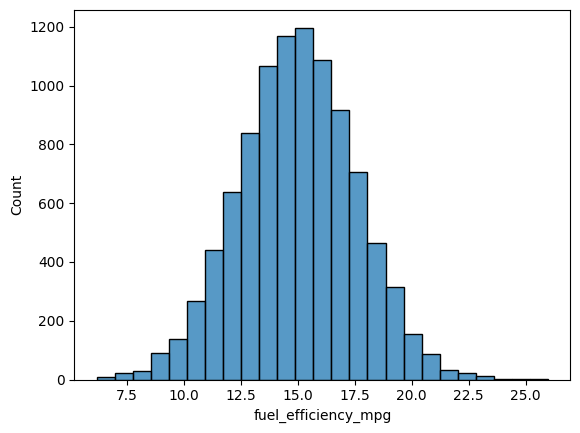

In [74]:
#Q1 No es long tail es una distribucion normal
sns.histplot(df.fuel_efficiency_mpg, bins=25)

In [87]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
fuel_efficiency_mpg      0
age                      0
dtype: int64

In [75]:
# Q2 Mean = 149
df.horsepower.describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [76]:
# Q3

n = len(df)

n_val= int(n * (0.2))
n_test= int(n * (0.2))
n_train= n - n_val - n_test

idx =  np.arange(n)
np.random.seed(42) 
np.random.shuffle (idx)

df_train = df.iloc [idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg'] 


In [77]:
# Datos Nulos (solo HORSEPOWER)
col_nulos= list(df.columns[df.isnull().sum() > 0])
col_nulos
for col in col_nulos:
    print (col,': ', df[col].isnull().sum())

horsepower :  708


In [78]:
# FUNCIONES

def prepare_X(df,fillna):
    df = df.copy()

    df_num = df
    df_num = df_num.fillna(fillna)
    X = df_num.values
    return X

def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])

    XTX = X.T.dot(X)
    XTX_INV = np.linalg.inv(XTX )
    w_full = XTX_INV.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = ( y_pred - y) ** 2 
    mse = se.mean() 
    return np.sqrt(mse) 

In [79]:
#Valores nulos horsepower por 0
X_train = prepare_X (df_train,fillna = 0)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X (df_val, fillna = 0)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

np.float64(0.52)

In [80]:
#Valores nulos horsepower por media
mean = df_train.horsepower.mean()
X_train = prepare_X (df_train,fillna = mean)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X (df_val, fillna = 0)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

## Rellenar con 0 seria la mejor opcion

np.float64(0.61)

In [ ]:
#Q4  REGULARIZACION con fillna 0 screen
def train_linear_regression_reg(X,y,r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])

    XTX = X.T.dot(X)
    XTX = XTX + r *np.eye(XTX.shape[0])

    XTX_INV = np.linalg.inv(XTX )
    w_full = XTX_INV.dot(X.T).dot(y)
    return w_full[0], w_full[1:] 

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X (df_train,fillna=0)
    w0, w = train_linear_regression_reg(X_train, y_train,r)

    X_val = prepare_X (df_val, fillna=0)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)

    print('r:',r,' ','score:', round(score,2))

# Seria 0.01

r: 0   score: 0.52
r: 0.01   score: 0.52
r: 0.1   score: 0.52
r: 1   score: 0.52
r: 5   score: 0.55
r: 10   score: 0.64
r: 100   score: 2.06


In [84]:
#Q5 For para ver los resultados de las distitnas seed y calcular desviacion standart
seed_scores= []
for s in [0,1,2,3,4,5,6,7,8,9]:
    n = len(df)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val+n_test)

    idx = np.arange(n) # crea un vector con numerso hasta n-1

    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop = True)
    df_val = df_val.reset_index(drop = True)
    df_test = df_test.reset_index(drop = True)
    y_train  = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test  = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']



    X_train = prepare_X (df_train,fillna=0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X (df_val,fillna=0)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    seed_scores.append(score)
    print(s, score)

round(np.std(seed_scores),3)


0 0.5206531296298016
1 0.5213388912856999
2 0.5228069974802074
3 0.5159516741173612
4 0.5109129460065411
5 0.5283406460165976
6 0.5313910658170673
7 0.5090670387374354
8 0.514739912935085
9 0.5131865908330963


np.float64(0.007)

In [90]:
# Q6 Concatenamos DF TRAIN Y VAL y lo probamos contra Test. Seed 9
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val+n_test)

idx = np.arange(n) # crea un vector con numerso hasta n-1

np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True) 
df_test = df_test.reset_index(drop = True)
y_train  = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test  = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']



df_full_train = pd.concat([df_train,df_val])
df_full_train = df_full_train.reset_index(drop = True)

y_full_train = np.concatenate([y_train, y_val])

X_full_train = prepare_X(df_full_train,fillna=0)
w0, w = train_linear_regression_reg(X_full_train, y_full_train,0.001)
X_test = prepare_X(df_test,fillna=0)
y_pred = w0 + X_test.dot(w)

round(rmse(y_test,y_pred),4)

np.float64(0.5156)